In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.linear_model import LinearRegression
import scipy.stats as stats
import math 
import statsmodels.api as sm
from statsmodels.formula.api import ols
from sklearn.feature_selection import RFE
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score

from sklearn.neighbors  import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score,confusion_matrix,roc_curve, auc, f1_score, classification_report
import itertools
sns.set(style='white')
%matplotlib inline
from sklearn.ensemble import ExtraTreesClassifier,RandomForestClassifier
from sklearn.linear_model import LogisticRegression

# Questions:
- Can a model help to eliminate some human error when conducting a terry stop? Quick, efficient, effective. How can officer be held accountable to not base decision solely off of traffic stop? Pre-screen answer (yes, I do plan to arrest. why?)
- Find previous terry stop examples and plug the data into the maching - did the machine work? Live PD?

# Obtain

In [2]:
stops = pd.read_csv('/Users/molly/downloads/terry_stops.csv')
stops.head()

,Subject Age Group,Subject ID,GO / SC Num,Terry Stop ID,Stop Resolution,Weapon Type,Officer ID,Officer YOB,Officer Gender,Officer Race,...,Reported Time,Initial Call Type,Final Call Type,Call Type,Officer Squad,Arrest Flag,Frisk Flag,Precinct,Sector,Beat
0,-,-1,20140000120677,92317,Arrest,None,7500,1984,M,Black or African American,...,11:32:00,-,-,-,SOUTH PCT 1ST W - ROBERT,N,N,South,O,O2
1,-,-1,20150000001463,28806,Field Contact,None,5670,1965,M,White,...,07:59:00,-,-,-,NaN,N,N,-,-,-
2,-,-1,20150000001516,29599,Field Contact,None,4844,1961,M,White,...,19:12:00,-,-,-,NaN,N,-,-,-,-
3,-,-1,20150000001670,32260,Field Contact,None,7539,1963,M,White,...,04:55:00,-,-,-,NaN,N,N,-,-,-
4,-,-1,20150000001739,33155,Field Contact,None,6973,1977,M,White,...,00:41:00,-,-,-,NaN,N,N,-,-,-


In [3]:
stops.shape

(47055, 23)

In [4]:
stops.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 47055 entries, 0 to 47054
Data columns (total 23 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   Subject Age Group         47055 non-null  object
 1   Subject ID                47055 non-null  int64 
 2   GO / SC Num               47055 non-null  int64 
 3   Terry Stop ID             47055 non-null  int64 
 4   Stop Resolution           47055 non-null  object
 5   Weapon Type               47055 non-null  object
 6   Officer ID                47055 non-null  object
 7   Officer YOB               47055 non-null  int64 
 8   Officer Gender            47055 non-null  object
 9   Officer Race              47055 non-null  object
 10  Subject Perceived Race    47055 non-null  object
 11  Subject Perceived Gender  47055 non-null  object
 12  Reported Date             47055 non-null  object
 13  Reported Time             47055 non-null  object
 14  Initial Call Type     

In [5]:
stops.describe()

,Subject ID,GO / SC Num,Terry Stop ID,Officer YOB
count,4.705500e+04,4.705500e+04,4.705500e+04,47055.000000
mean,2.516630e+09,2.017587e+13,3.563128e+09,1982.944724
std,4.543835e+09,1.734325e+10,6.227849e+09,9.080075
min,-1.000000e+00,2.009000e+13,2.802000e+04,1900.000000
25%,-1.000000e+00,2.016000e+13,1.812635e+05,1978.000000
50%,-1.000000e+00,2.018000e+13,4.027170e+05,1985.000000
75%,7.725872e+09,2.019000e+13,8.301896e+09,1990.000000
max,2.273536e+10,2.021000e+13,2.275532e+10,1998.000000


### Immediate observations: 
- 23 headings is a lot - how many can I get rid of initially? 
- most dtypes are objects, not many integers
- almost all are non-null (exception: officer squad)
- minimum year of birth is seemingly too old: when did data start being recorded?  
- the other integers aren't interesting 

# Scrub

## 1. Subject Age Group

In [6]:
# to count unique Subject Age Group Values
print(stops.groupby('Subject Age Group')['Terry Stop ID'].nunique())

Subject Age Group
-                1540
1 - 17           1975
18 - 25          9424
26 - 35         15645
36 - 45          9958
46 - 55          6088
56 and Above     2386
Name: Terry Stop ID, dtype: int64


#### Subject Age Group Key: 
1. 1 - 17 
2. 18 - 25
3. 26 - 35
4. 36 - 45
5. 46 - 55
7. 55 - 74 

In [7]:
# to change Subject Age Group to an integer, I will replace each value with a numerical variable 1-5 (key above): 
#to replace object values with integer values 1-6 
stops['Subject Age Group'].replace('1 - 17',1,inplace=True)
stops['Subject Age Group'].replace('18 - 25',2,inplace=True)
stops['Subject Age Group'].replace('26 - 35',3,inplace=True)
stops['Subject Age Group'].replace('36 - 45',4,inplace=True)
stops['Subject Age Group'].replace('46 - 55',5,inplace=True)
stops['Subject Age Group'].replace('56 and Above',6,inplace=True)

#to change values of "-" in subject age group to 26-35 
stops['Subject Age Group'].replace('-',1,inplace=True)

#to convert Subject Age Group to a dtype of integer 
stops['Subject Age Group'] = stops['Subject Age Group'].astype(int)

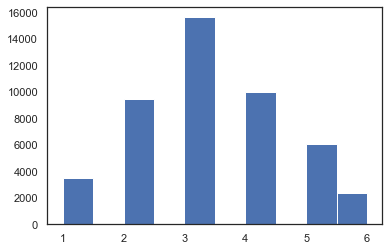

In [8]:
plt.hist(stops['Subject Age Group'])
plt.show()

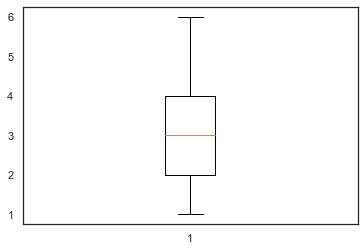

In [9]:
plt.boxplot(stops['Subject Age Group'])
plt.show()

## 2. Subject I.D.

In [10]:
# to count unique Subject I.D Values
print(stops.groupby('Subject ID')['Terry Stop ID'].nunique())

Subject ID
-1              34761
 7704448659         1
 7704448966         1
 7704461371         1
 7704462099         1
                ...  
 22610447033        1
 22626518671        1
 22690356047        1
 22720811395        1
 22735359602        1
Name: Terry Stop ID, Length: 9078, dtype: int64


Many of the subject IDs are listed as -1. To me, this may be a useless column. According to the website, the ID are:
Key, generated daily, identifying unique subjects in the dataset using a character to character match of first name and last name. "Null" values indicate an "anonymous" or "unidentified" subject. Subjects of a Terry Stop are not required to present identification.

I believe that it would be safe to drop this column, as Subject I.Ds are not dependant on any defining factors. 

In [11]:
#to drop Subject ID: 
stops = stops.drop(columns=['Subject ID'])

## 3. GO / SC Num:
According to the website, the GO/SC Num is: 
General Offense or Street Check number, relating the Terry Stop to the parent report. This field may have a one to many relationship in the data

This description is nonsensical to me as it stands. I am going to further investigate the data to see if it will begin to make sense. 


In [12]:
# to count unique Subject I.D Values
print(stops.groupby('GO / SC Num')['Terry Stop ID'].nunique())

GO / SC Num
20090000228667    3
20100000074003    1
20110000363140    1
20120000210981    1
20120000271417    1
                 ..
20210000085680    1
20210000085705    1
20210000085724    1
20210000086052    1
20210000086119    1
Name: Terry Stop ID, Length: 36898, dtype: int64


In [13]:
stops['GO / SC Num'].head(10)

0    20140000120677
1    20150000001463
2    20150000001516
3    20150000001670
4    20150000001739
5    20150000001755
6    20150000002351
7    20150000002363
8    20150000002392
9    20150000002451
Name: GO / SC Num, dtype: int64

I believe the first four digts in the string are the year recorded. I am going to eliminate this column. 

In [14]:
#to drop Subject ID: 
stops = stops.drop(columns=['GO / SC Num'])

## 4. Terry Stop ID:

## 5. Stop Resolution:

In [15]:
# to count unique Stop Resolution Values
print(stops.groupby('Stop Resolution')['Terry Stop ID'].nunique())

Stop Resolution
Arrest                      11590
Citation / Infraction         178
Field Contact               18914
Offense Report              15606
Referred for Prosecution      728
Name: Terry Stop ID, dtype: int64


In [16]:
#to divide data into arrest(1) vs. no arrest(0):
stops['Stop Resolution'] = stops['Stop Resolution'].map(lambda x: 1 if x == "Arrest" else 0)
#stops.drop('Stop Resolution', axis = 1, inplace = True)

In [17]:
#check: 
# to count unique Subject I.D Values
print(stops.groupby('Stop Resolution')['Terry Stop ID'].nunique())

Stop Resolution
0    35426
1    11590
Name: Terry Stop ID, dtype: int64


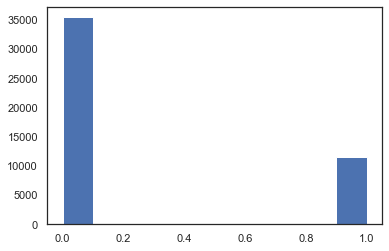

In [18]:
plt.hist(stops['Stop Resolution'])
plt.show()

As I moved further along, I noticed that arrest already had a category: arrest flag. The data is not identical, but I am going to assume the arrest flag data is more accurate in arrest flag and drop arrest for stops2. 

## 6. Weapon Type:

In [19]:
# to count unique Weapon Type Values
print(stops.groupby('Weapon Type')['Terry Stop ID'].nunique())

Weapon Type
-                                       11711
Automatic Handgun                           2
Blackjack                                   1
Blunt Object/Striking Implement            84
Brass Knuckles                              1
Club                                        9
Club, Blackjack, Brass Knuckles            49
Fire/Incendiary Device                      6
Firearm                                    36
Firearm (unk type)                         15
Firearm Other                             100
Handgun                                   291
Knife/Cutting/Stabbing Instrument         623
Lethal Cutting Instrument                1482
Mace/Pepper Spray                          28
None                                    32565
None/Not Applicable                         7
Other Firearm                              23
Personal Weapons (hands, feet, etc.)        2
Rifle                                       7
Shotgun                                     3
Taser/Stun Gun        

In [20]:
# to split Weapon Type into None(0), Firearm(1), or Other(2): 

#to replace "-" with 0: 
stops['Weapon Type'].replace('-',0,inplace=True)

#to replace "None", "None/Not Applicable" with 0:
stops['Weapon Type'].replace('None',0,inplace=True)
stops['Weapon Type'].replace('None/Not Applicable',0,inplace=True)

#to replace "Automatic Handgun", "Firearm", "Firearm (unk type)", "Firearm Other", "Handgun", "Other Firearm"
#"Rifle", and "Shotgun" with 1: 
stops['Weapon Type'].replace('Automatic Handgun',1,inplace=True)
stops['Weapon Type'].replace('Firearm',1,inplace=True)
stops['Weapon Type'].replace('Firearm (unk type)',1,inplace=True)
stops['Weapon Type'].replace('Firearm Other',1,inplace=True)
stops['Weapon Type'].replace('Handgun',1,inplace=True)
stops['Weapon Type'].replace('Other Firearm',1,inplace=True)
stops['Weapon Type'].replace('Rifle',1,inplace=True)
stops['Weapon Type'].replace('Shotgun',1,inplace=True)

#to replace the remaining weapon types with 1: 
stops['Weapon Type'].replace('Blackjack',1,inplace=True)
stops['Weapon Type'].replace('Blunt Object/Striking Implement',1,inplace=True)
stops['Weapon Type'].replace('Brass Knuckles',1,inplace=True)
stops['Weapon Type'].replace('Club',1,inplace=True)
stops['Weapon Type'].replace('Club, Blackjack, Brass Knuckles',1,inplace=True)
stops['Weapon Type'].replace('Fire/Incendiary Device',1,inplace=True)
stops['Weapon Type'].replace('Knife/Cutting/Stabbing Instrument',1,inplace=True)
stops['Weapon Type'].replace('Lethal Cutting Instrument',1,inplace=True)
stops['Weapon Type'].replace('Mace/Pepper Spray',1,inplace=True)
stops['Weapon Type'].replace('Personal Weapons (hands, feet, etc.)',1,inplace=True)
stops['Weapon Type'].replace('Taser/Stun Gun',1,inplace=True)

In [21]:
#Check: 
print(stops.groupby('Weapon Type')['Terry Stop ID'].nunique())

Weapon Type
0    44283
1     2733
Name: Terry Stop ID, dtype: int64


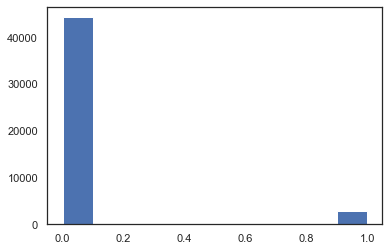

In [22]:
plt.hist(stops['Weapon Type'])
plt.show()

## 7. Officer ID: 

In [23]:
stops['Officer ID'].head(10)

0    7500  
1    5670  
2    4844  
3    7539  
4    6973  
5    7402  
6    7591  
7    7591  
8    7560  
9    7591  
Name: Officer ID, dtype: object

In [24]:
#dropping officer ID for lack of use: 
stops = stops.drop(columns=['Officer ID'])

## 8. Officer YOB

In [25]:
# to count unique Officer YOB Values
print(stops.groupby('Officer YOB')['Terry Stop ID'].nunique())

Officer YOB
1900      35
1946       2
1948      11
1949       5
1951       1
1952       9
1953      33
1954      44
1955      21
1956      17
1957      43
1958     219
1959     174
1960     161
1961     214
1962     456
1963     260
1964     428
1965     419
1966     223
1967     710
1968     628
1969     542
1970     599
1971    1226
1972     426
1973     921
1974     556
1975     531
1976    1021
1977    1009
1978    1154
1979    1521
1980     808
1981    1429
1982    1847
1983    1719
1984    2745
1985    2487
1986    3299
1987    2999
1988    2115
1989    1990
1990    2231
1991    2695
1992    2441
1993    1464
1994     909
1995    1152
1996     647
1997     399
1998      21
Name: Terry Stop ID, dtype: int64


In [26]:
stops['Officer YOB'].describe()

count    47055.000000
mean      1982.944724
std          9.080075
min       1900.000000
25%       1978.000000
50%       1985.000000
75%       1990.000000
max       1998.000000
Name: Officer YOB, dtype: float64

In [27]:
#replacing the 1900 data points (which must be a recording error) with the median of 1985
stops['Officer YOB'].replace(1900, 1985, inplace=True)

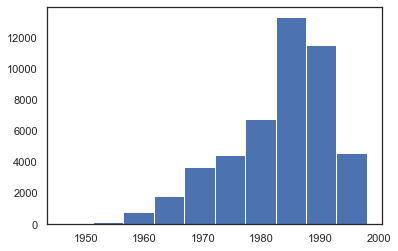

In [28]:
plt.hist(stops['Officer YOB'])
plt.show()

In [29]:
stops['Officer YOB'].describe()

count    47055.000000
mean      1983.007948
std          8.793720
min       1946.000000
25%       1978.000000
50%       1985.000000
75%       1990.000000
max       1998.000000
Name: Officer YOB, dtype: float64

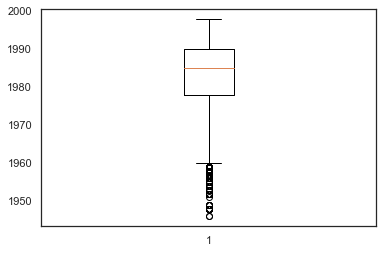

In [30]:
plt.boxplot(stops['Officer YOB'])
plt.show()

In [31]:
stops2 = stops
stops2 = stops2[stops2['Officer YOB'] > 1963]

In [32]:
stops2['Officer YOB'].unique()

array([1984, 1965, 1977, 1973, 1985, 1986, 1964, 1979, 1981, 1969, 1983,
       1966, 1968, 1987, 1970, 1976, 1972, 1982, 1991, 1988, 1971, 1978,
       1990, 1975, 1967, 1992, 1980, 1989, 1974, 1994, 1993, 1996, 1995,
       1997, 1998])

In [33]:
stops2['Officer YOB'].describe()

count    45385.000000
mean      1983.850127
std          7.739693
min       1964.000000
25%       1979.000000
50%       1985.000000
75%       1990.000000
max       1998.000000
Name: Officer YOB, dtype: float64

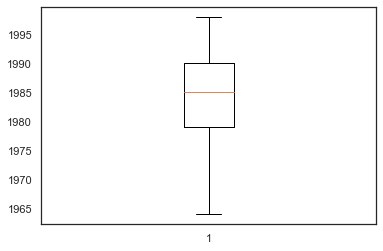

In [34]:
plt.boxplot(stops2['Officer YOB'])
plt.show()

## 9. Officer Gender:

In [35]:
# to count unique Officer Gender Values
print(stops.groupby('Officer Gender')['Terry Stop ID'].nunique())

Officer Gender
F     5378
M    41609
N       29
Name: Terry Stop ID, dtype: int64


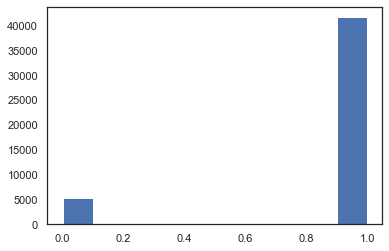

In [36]:
stops['Officer Male'] = stops['Officer Gender'].map(lambda x: 0 if x == 'F' else 1)
stops.drop('Officer Gender', axis = 1, inplace = True)
plt.hist(stops['Officer Male'])
plt.show()

## 10. Officer Race:

In [37]:
# to count unique Officer Gender Values
print(stops.groupby('Officer Race')['Terry Stop ID'].nunique())

Officer Race
American Indian/Alaska Native      317
Asian                             2013
Black or African American         1873
Hispanic or Latino                2727
Nat Hawaiian/Oth Pac Islander      454
Not Specified                     1449
Two or More Races                 2634
Unknown                             35
White                            35514
Name: Terry Stop ID, dtype: int64


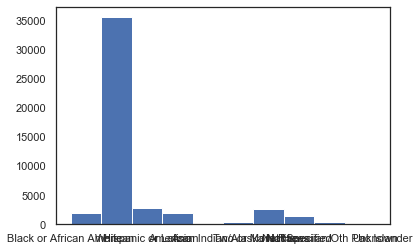

In [38]:
plt.hist(stops['Officer Race'])
plt.show()

In [39]:
#create numerical values for white (0), or other (1)
#to replace white with 0
stops['Officer Race'].replace('White',0,inplace=True)

#to replace other with 1 
stops['Officer Race'].replace('Asian',1,inplace=True)
stops['Officer Race'].replace('Black or African American',1,inplace=True)
stops['Officer Race'].replace('Hispanic or Latino',1,inplace=True)
stops['Officer Race'].replace('Nat Hawaiian/Oth Pac Islander',1,inplace=True)
stops['Officer Race'].replace('Not Specified',1,inplace=True)
stops['Officer Race'].replace('Two or More Races',1,inplace=True)
stops['Officer Race'].replace('Unknown',1,inplace=True)
stops['Officer Race'].replace('American Indian/Alaska Native',1,inplace=True)

In [40]:
print(stops.groupby('Officer Race')['Terry Stop ID'].nunique())

Officer Race
0    35514
1    11502
Name: Terry Stop ID, dtype: int64


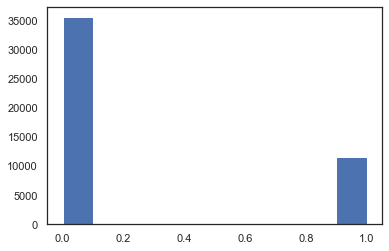

In [41]:
plt.hist(stops['Officer Race'])
plt.show()

## 11. Subject Perceived Race: 

In [42]:
# to count unique Subject Perceived Race Values
print(stops.groupby('Subject Perceived Race')['Terry Stop ID'].nunique())

Subject Perceived Race
-                                             1892
American Indian or Alaska Native              1351
Asian                                         1526
Black or African American                    13985
Hispanic                                      1684
Multi-Racial                                   809
Native Hawaiian or Other Pacific Islander       54
Other                                          152
Unknown                                       2605
White                                        22958
Name: Terry Stop ID, dtype: int64


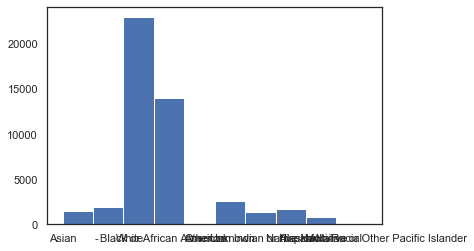

In [43]:
plt.hist(stops['Subject Perceived Race'])
plt.show()

In [44]:
#create numerical values for white (0), black or AA (1), or other (2)
#to replace white with 0
stops['Subject Perceived Race'].replace('White',0,inplace=True)

#to replace Black or African American with 1 
stops['Subject Perceived Race'].replace('Black or African American',1,inplace=True)

#to replace all other races with 2
stops['Subject Perceived Race'].replace('American Indian or Alaska Native',1,inplace=True)
stops['Subject Perceived Race'].replace('Asian',1,inplace=True)
stops['Subject Perceived Race'].replace('Hispanic',1,inplace=True)
stops['Subject Perceived Race'].replace('Multi-Racial',1,inplace=True)
stops['Subject Perceived Race'].replace('Native Hawaiian or Other Pacific Islander',1,inplace=True)
stops['Subject Perceived Race'].replace('Other',1,inplace=True)
stops['Subject Perceived Race'].replace('Unknown',1,inplace=True)
stops['Subject Perceived Race'].replace('-',1,inplace=True)


In [45]:
print(stops.groupby('Subject Perceived Race')['Terry Stop ID'].nunique())

Subject Perceived Race
0    22958
1    24058
Name: Terry Stop ID, dtype: int64


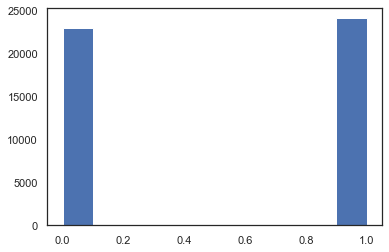

In [46]:
plt.hist(stops['Subject Perceived Race'])
plt.show()

## 12. Subject Perceived Gender:

In [47]:
# to count unique Subject Perceived Gender Values
print(stops.groupby('Subject Perceived Gender')['Terry Stop ID'].nunique())

Subject Perceived Gender
-                                                              280
Female                                                        9544
Gender Diverse (gender non-conforming and/or transgender)        5
Male                                                         36836
Unable to Determine                                            326
Unknown                                                         25
Name: Terry Stop ID, dtype: int64


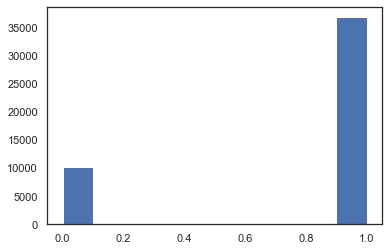

In [48]:
#to create a binary of male v. other including female, gender diverse, et. 
stops['Subject Male'] = stops['Subject Perceived Gender'].map(lambda x: 1 if x == 'Male' else 0)
stops.drop('Subject Perceived Gender', axis = 1, inplace = True)
plt.hist(stops['Subject Male'])
plt.show()


## 13. Reported Date: 
- split date into year and month, drop day 

In [49]:
#to examine Reported Date 
stops['Reported Date'].head()

0    2015-10-16T00:00:00
1    2015-03-19T00:00:00
2    2015-03-21T00:00:00
3    2015-04-01T00:00:00
4    2015-04-03T00:00:00
Name: Reported Date, dtype: object

In [50]:
#to separate year: 
date = stops['Reported Date']
date['Year'] =  date.str.split("-", n=1, expand=True)
date['Year'][:4]

/Users/molly/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


,0,1
0,2015,10-16T00:00:00
1,2015,03-19T00:00:00
2,2015,03-21T00:00:00
3,2015,04-01T00:00:00


In [51]:
#to make separated year into a column in the df
stops['Reported Year'] = date.Year[0]
stops['Reported Year'] = stops['Reported Year'].astype(int)

In [52]:
#to repeat the steps for month: 
month = date.Year[1]
month['Month'] = month.str.split('-', n=1, expand=True)
month['Month']

,0,1
0,10,16T00:00:00
1,03,19T00:00:00
2,03,21T00:00:00
3,04,01T00:00:00
4,04,03T00:00:00
...,...,...
47050,02,20T00:00:00
47051,01,14T00:00:00
47052,03,15T00:00:00
47053,03,11T00:00:00


In [53]:
stops['Reported Month'] = month.Month[0]

stops['Reported Month']= stops['Reported Month'].astype(int)

#to drop Reported Date: 
stops = stops.drop(columns=['Reported Date'])

## 14. Reported Time: 

In [54]:
stops['Reported Time'].head()

0    11:32:00
1    07:59:00
2    19:12:00
3    04:55:00
4    00:41:00
Name: Reported Time, dtype: object

In [55]:
#to separate hour from reported time: 
hour = stops['Reported Time']
hour['Hour'] = hour.str.split(':', n=1, expand=True)
hour['Hour']
stops['Reported Hour'] = hour['Hour'][0]
stops['Reported Hour'].head()

/Users/molly/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


0    11
1    07
2    19
3    04
4    00
Name: Reported Hour, dtype: object

In [56]:
#to create a new column for reported hour:
stops['Reported Hour'] = stops['Reported Hour'].astype(int)

#to drop the reported time column: 
stops = stops.drop(columns=['Reported Time'])

print(stops.groupby('Reported Hour')['Terry Stop ID'].nunique())

Reported Hour
0     2154
1     2334
2     2740
3     2515
4     1446
5     1503
6     1208
7     1286
8     1303
9     1456
10    1833
11    1921
12    1585
13    1845
14    2083
15    2144
16    2255
17    2494
18    2866
19    2585
20    1439
21    1692
22    1990
23    2339
Name: Terry Stop ID, dtype: int64


In [57]:
# 1-24 makes more sense in hours than 0-23 
#to assemble a function to add 1 to each hour value: 
def add_one(x):
	return x + 1

stops['Reported Hour'] = stops['Reported Hour'].apply(add_one)

In [58]:
#to check for completion: 
stops['Reported Hour'].unique()

array([12,  8, 20,  5,  1, 24, 22, 23,  2, 16, 13,  3, 11, 10, 15,  6,  9,
       19,  4, 21,  7, 14, 18, 17])

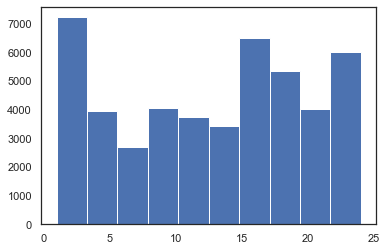

In [59]:
plt.hist(stops['Reported Hour'])
plt.show()

## 15. Initial Call Type: 

In [60]:
# to count unique Initial Call Type Values
print(stops.groupby('Initial Call Type')['Terry Stop ID'].nunique())

Initial Call Type
-                                                 13147
-ASSIGNED DUTY - FOOT BEAT (FROM ASSIGNED CAR)        6
-ASSIGNED DUTY - STAKEOUT                             1
ALARM - ATM MACHINE, FREE STANDING                    1
ALARM - AUDIBLE AUTOMOBILE (UNOCC/ANTI-THEFT)         3
                                                  ...  
WARRANT - SEARCH. CAUTION (EXCL NARCOTICS)           34
WARRANT - SEARCH. EXECUTED, SECURED                  40
WARRANT PICKUP - FROM OTHER AGENCY                    1
WEAPN - GUN,DEADLY WPN (NO THRTS/ASLT/DIST)         188
WEAPN-IP/JO-GUN,DEADLY WPN (NO THRT/ASLT/DIST)     1141
Name: Terry Stop ID, Length: 167, dtype: int64


In [61]:
stops['Initial Call Type'].unique()

array(['-', 'DIST - IP/JO - DV DIST - NO ASLT',
       'THEFT (DOES NOT INCLUDE SHOPLIFT OR SVCS)',
       'DISTURBANCE, MISCELLANEOUS/OTHER',
       'SUSPICIOUS PERSON, VEHICLE OR INCIDENT',
       'SUSPICIOUS STOP - OFFICER INITIATED ONVIEW',
       'SHOTS - IP/JO - INCLUDES HEARD/NO ASSAULT', 'SHOPLIFT - THEFT',
       'NARCOTICS - VIOLATIONS (LOITER, USE, SELL, NARS)',
       'MVC - HIT AND RUN (NON INJURY), INCLUDES IP/JO',
       'ASLT - IP/JO - WITH OR W/O WPNS (NO SHOOTINGS)', 'TRESPASS',
       'MVC - WITH INJURIES (INCLUDES HIT AND RUN)',
       'FIGHT - VERBAL/ORAL (NO WEAPONS)',
       'WEAPN-IP/JO-GUN,DEADLY WPN (NO THRT/ASLT/DIST)', 'AUTO RECOVERY',
       'PROWLER - IP/JO', 'PERSON IN BEHAVIORAL/EMOTIONAL CRISIS',
       'FIGHT - IP - PHYSICAL (NO WEAPONS)',
       'BURG - IP/JO - RES (INCL UNOCC STRUCTURES)',
       'TRAFFIC STOP - OFFICER INITIATED ONVIEW', 'NUISANCE - MISCHIEF',
       'HAZ - POTENTIAL THRT TO PHYS SAFETY (NO HAZMAT)',
       'WARRANT - MISD WARRANT P

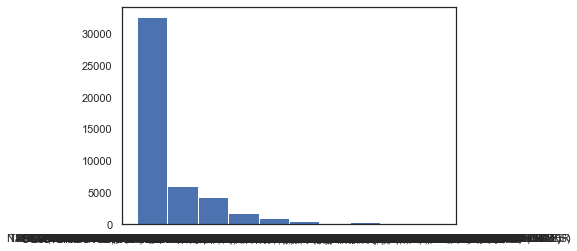

In [62]:
plt.hist(stops['Initial Call Type'])
plt.show()

In [63]:
#because over 13,000 of these values are null, I am going to drop this column. 
stops = stops.drop(columns=['Initial Call Type'])

## 16. Final Call Type:

In [64]:
# to count unique Final Call Type Values
print(stops.groupby('Final Call Type')['Terry Stop ID'].nunique())

Final Call Type
-                                                  13147
--ALARM-COMM (INC BANK, ATM, SCHOOLS, BSN)            51
--ALARM-COMM ROBB (BANK, PANIC, DURESS)                8
--ALARM-OTHER (VARDA,PDT,FIRE,LOCAL,METRO,ETC))        6
--ALARM-RESIDENTIAL BURG                              10
                                                   ...  
WARRANT - FELONY PICKUP                               12
WARRANT - MISD WARRANT PICKUP                         10
WARRANT PICKUP - FROM OTHER AGENCY                     1
WEAPN - GUN,DEADLY WPN (NO THRTS/ASLT/DIST)            4
WEAPN-IP/JO-GUN,DEADLY WPN (NO THRT/ASLT/DIST)         6
Name: Terry Stop ID, Length: 207, dtype: int64


In [65]:
#again, over 13,000 of these values are null. I will drop this column as well: 
stops = stops.drop(columns = ['Final Call Type'])

## 17. Call Type

In [66]:
# to count unique Call Type Values
print(stops.groupby('Call Type')['Terry Stop ID'].nunique())

Call Type
-                                13147
911                              21152
ALARM CALL (NOT POLICE ALARM)      333
ONVIEW                            9078
SCHEDULED EVENT (RECURRING)          1
TELEPHONE OTHER, NOT 911          3298
TEXT MESSAGE                         7
Name: Terry Stop ID, dtype: int64


In [67]:
#over 13,000 of these values are null as well. to drop: 
stops = stops.drop(columns = ['Call Type'])

## 18. Officer Squad: 

In [68]:
# to count unique Officer Squad Values
print(stops.groupby('Officer Squad')['Terry Stop ID'].nunique())

Officer Squad
AUTO THEFT                              8
BURG/THEFT/JUV - EAST                   5
BURG/THEFT/JUV - NORTH                  1
BURG/THEFT/JUV - SOUTH                  6
BURG/THEFT/JUV - WEST                   1
                                       ..
WEST PCT OPS - COMMERCIAL SEC           1
WEST PCT OPS - CPT                     75
WEST PCT OPS - MOUNTED PATROL           9
WEST PCT OPS - SEA CTR                 10
ZOLD CRIME ANALYSIS UNIT - ANALYSTS     1
Name: Terry Stop ID, Length: 172, dtype: int64


In [69]:
stops['Officer Squad'].astype(str)
stops['Officer Squad'].fillna("na", inplace= True)

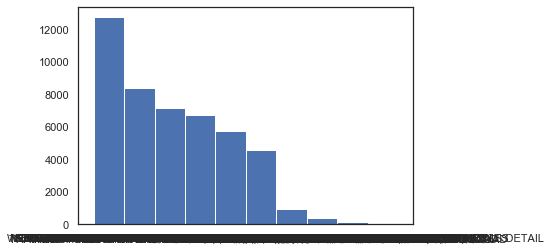

In [70]:
plt.hist(stops['Officer Squad'])
plt.show()

## 19. Arrest Flag 
According to the website, this variable indicates whether an arrest was made. 

In [71]:
# to count unique Arrest Flag Values
print(stops.groupby('Arrest Flag')['Terry Stop ID'].nunique())

Arrest Flag
N    43634
Y     3382
Name: Terry Stop ID, dtype: int64


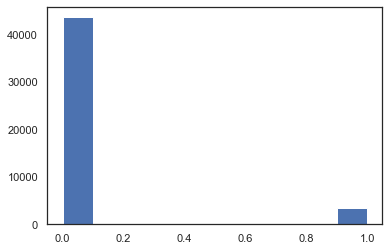

In [72]:
#to replace N with 0 and Y with 1 
stops['Arrest Flag'].replace('N',0,inplace=True)
stops['Arrest Flag'].replace('Y',1,inplace=True)

plt.hist(stops['Arrest Flag'])
plt.show()

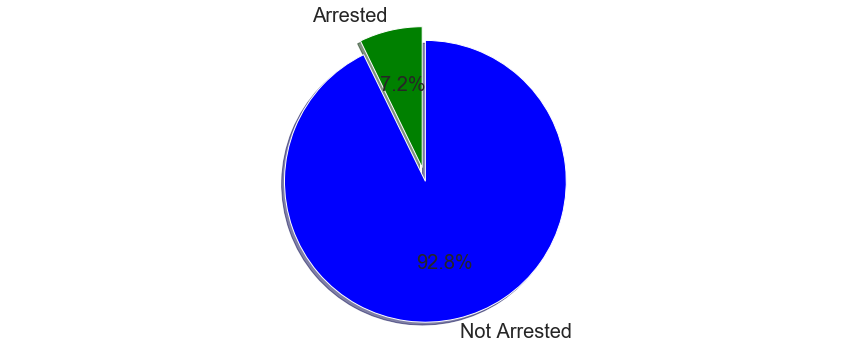

In [73]:
# Create chart labels and calculate the size of each piece of the pie:
labels = 'Arrested', 'Not Arrested'
sizes = [stops['Arrest Flag'].sum(), (len(stops['Arrest Flag'])-stops['Arrest Flag'].sum())]
explode = (0.1, 0)  # "explode" the arrested slice

# Create a pie chart showing % arrested vs. % not arrested:
fig1, ax1 = plt.subplots(figsize=(15,6))
ax1.pie(sizes, explode=explode, colors = ['Green','Blue'],labels=labels, autopct='%1.1f%%',
        shadow=True, startangle=90,textprops={'fontsize': 20})
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.show();

Why is this data different from Stop Resolution? How different is it? 

## 20. Frisk Flag: 
This variable indicates whether or not a frist was performed by an officer: 

In [74]:
# to count unique Frisk Flag Values
print(stops.groupby('Frisk Flag')['Terry Stop ID'].nunique())

Frisk Flag
-      478
N    36029
Y    10509
Name: Terry Stop ID, dtype: int64


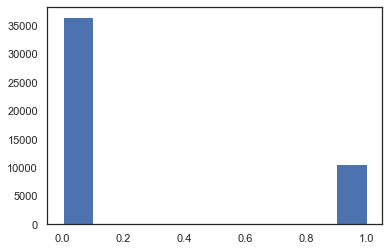

In [75]:
#to replace - and N with 0 and Y with 1: 
stops['Frisk Flag'].replace('N',0,inplace=True)
stops['Frisk Flag'].replace('-',0,inplace=True)
stops['Frisk Flag'].replace('Y',1,inplace=True)

plt.hist(stops['Frisk Flag'])
plt.show()

## 21. Precinct: 

In [76]:
print(stops.groupby('Precinct')['Terry Stop ID'].nunique())

Precinct
-             9846
East          6173
FK ERROR        20
North        10349
OOJ             33
South         5622
SouthWest     1081
Southwest     2320
Unknown        200
West         11372
Name: Terry Stop ID, dtype: int64


## 22. Sector: 

In [77]:
# to count unique Sector Values
print(stops.groupby('Sector')['Terry Stop ID'].nunique())

Sector
-         10052
99           53
B           505
B          1658
C           373
C          1037
D          1127
D          1512
E           906
E          2337
F           657
F          1378
G           432
G          1087
J           390
J          1119
K          1712
K          1762
L           406
L          1639
M          1237
M          2270
N           689
N          2191
O           591
O          1161
Q           781
Q           967
R           600
R          1455
S           468
S          1348
U           450
U          1302
W           423
W           941
Name: Terry Stop ID, dtype: int64


In [78]:
stops['Sector'].unique()

array(['O     ', '-', 'E     ', 'C     ', 'N     ', 'U     ', 'K     ',
       'L     ', 'G     ', 'F     ', 'R     ', 'W     ', 'J     ',
       'M     ', 'D     ', 'S     ', 'B     ', 'K', 'Q     ', '99    ',
       'C', 'O', 'R', 'D', 'G', 'B', 'S', 'U', 'F', 'E', 'W', 'N', 'M',
       'Q', 'J', 'L'], dtype=object)

In [79]:
#to combine like sectors: 
stops['Sector'].replace('O     ','O',inplace=True)
stops['Sector'].replace('E     ','E',inplace=True)
stops['Sector'].replace('C     ','C',inplace=True)
stops['Sector'].replace('N     ','N',inplace=True)
stops['Sector'].replace('U     ','U',inplace=True)
stops['Sector'].replace('K     ','K',inplace=True)
stops['Sector'].replace('L     ','L',inplace=True)
stops['Sector'].replace('G     ','G',inplace=True)
stops['Sector'].replace('F     ','F',inplace=True)
stops['Sector'].replace('R     ','R',inplace=True)
stops['Sector'].replace('W     ','W',inplace=True)
stops['Sector'].replace('J     ','J',inplace=True)
stops['Sector'].replace('M     ','M',inplace=True)
stops['Sector'].replace('D     ','D',inplace=True)
stops['Sector'].replace('S     ','S',inplace=True)
stops['Sector'].replace('B     ','B',inplace=True)
stops['Sector'].replace('K     ','K',inplace=True)
stops['Sector'].replace('Q     ','Q',inplace=True)

In [80]:
print(stops.groupby('Sector')['Terry Stop ID'].nunique())

Sector
-         10052
99           53
B          2163
C          1410
D          2639
E          3243
F          2035
G          1519
J          1509
K          3474
L          2045
M          3507
N          2880
O          1752
Q          1748
R          2055
S          1816
U          1752
W          1364
Name: Terry Stop ID, dtype: int64


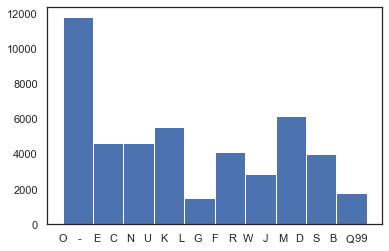

In [81]:
plt.hist(stops['Sector'])
plt.show()

In [82]:
#because so many of the sector values are missing, and the data looks scattered, I am dropping sector 
stops = stops.drop(columns=['Sector'])

## 23. Beat: 
According to the website: 
Beat of the address associated with the underlying Computer Aided Dispatch (CAD) event. Not necessarily where the Terry Stop occurred.

In [83]:
print(stops.groupby('Beat')['Terry Stop ID'].nunique())

Beat
-         9991
99          32
99          53
B1         186
B1         643
          ... 
W1         328
W2         194
W2         385
W3         110
W3         228
Name: Terry Stop ID, Length: 107, dtype: int64


In [84]:
#to drop beat: 
stops = stops.drop(columns = ['Beat'])

# Explore: 

In [85]:
stops.head()

,Subject Age Group,Terry Stop ID,Stop Resolution,Weapon Type,Officer YOB,Officer Race,Subject Perceived Race,Officer Squad,Arrest Flag,Frisk Flag,Precinct,Officer Male,Subject Male,Reported Year,Reported Month,Reported Hour
0,1,92317,1,0,1984,1,1,SOUTH PCT 1ST W - ROBERT,0,0,South,1,1,2015,10,12
1,1,28806,0,0,1965,0,1,na,0,0,-,1,0,2015,3,8
2,1,29599,0,0,1961,0,0,na,0,0,-,1,1,2015,3,20
3,1,32260,0,0,1963,0,1,na,0,0,-,1,0,2015,4,5
4,1,33155,0,0,1977,0,1,na,0,0,-,1,1,2015,4,1


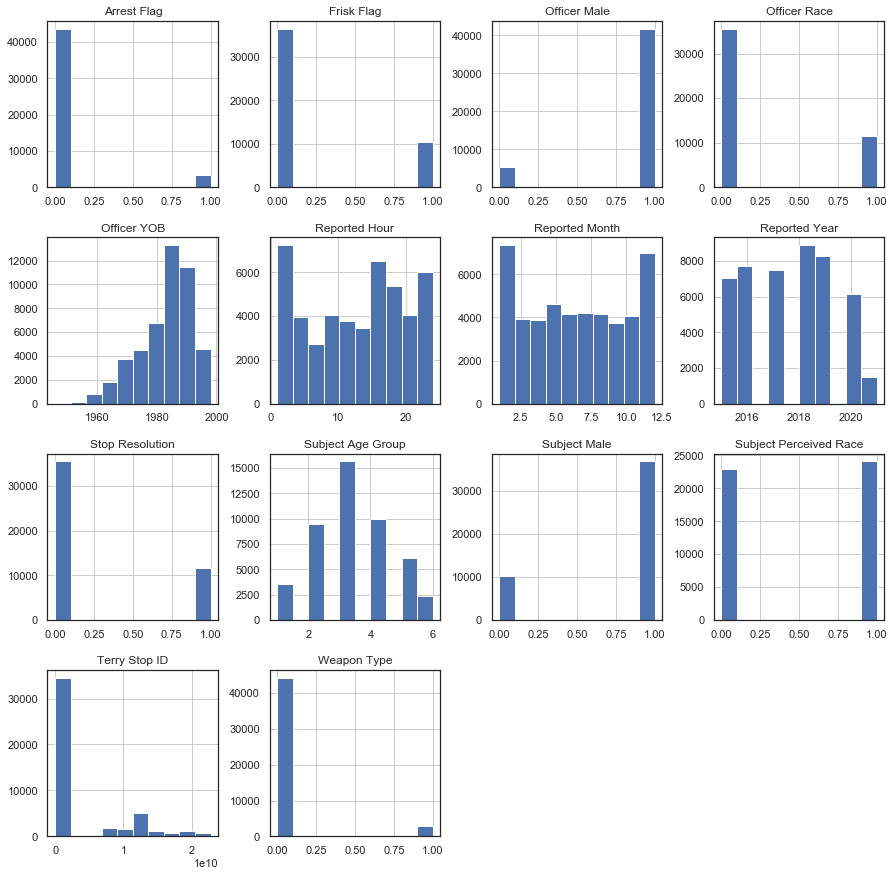

In [86]:
stops.hist(figsize = (15,15))
plt.show()

In [87]:
#making a copy of the data without the price -y value-
stops_pred = stops.drop('Arrest Flag', axis = 1)

#checking for significant correlations between predictors
df=stops_pred.corr().abs().stack().reset_index().sort_values(0, ascending=False)

# zip the variable name columns into a new column named "pairs"
df['pairs'] = list(zip(df.level_0, df.level_1))

# set index to pairs
df.set_index(['pairs'], inplace = True)

#d rop level columns
df.drop(columns=['level_1', 'level_0'], inplace = True)

# rename correlation column as cc rather than 0
df.columns = ['cc']

df.drop_duplicates(inplace=True)

df[(df.cc>.75) & (df.cc <1.1)]

,cc
pairs,
"(Subject Age Group, Subject Age Group)",1.000000
"(Reported Year, Terry Stop ID)",0.761114


In [88]:
stops.describe()

,Subject Age Group,Terry Stop ID,Stop Resolution,Weapon Type,Officer YOB,Officer Race,Subject Perceived Race,Arrest Flag,Frisk Flag,Officer Male,Subject Male,Reported Year,Reported Month,Reported Hour
count,47055.000000,4.705500e+04,47055.000000,47055.000000,47055.000000,47055.000000,47055.000000,47055.000000,47055.000000,47055.000000,47055.000000,47055.00000,47055.000000,47055.000000
mean,3.273063,3.563128e+09,0.246648,0.058910,1983.007948,0.244629,0.511635,0.072213,0.224163,0.885559,0.783487,2017.59575,6.443184,12.768994
std,1.269406,6.227849e+09,0.431064,0.235458,8.793720,0.429871,0.499870,0.258844,0.417034,0.318349,0.411872,1.72854,3.358725,7.177147
min,1.000000,2.802000e+04,0.000000,0.000000,1946.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2015.00000,1.000000,1.000000
25%,2.000000,1.812635e+05,0.000000,0.000000,1978.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,2016.00000,4.000000,6.000000
50%,3.000000,4.027170e+05,0.000000,0.000000,1985.000000,0.000000,1.000000,0.000000,0.000000,1.000000,1.000000,2018.00000,6.000000,14.000000
75%,4.000000,8.301896e+09,0.000000,0.000000,1990.000000,0.000000,1.000000,0.000000,0.000000,1.000000,1.000000,2019.00000,9.000000,19.000000
max,6.000000,2.275532e+10,1.000000,1.000000,1998.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,2021.00000,12.000000,24.000000


Text(0.5, 1, 'Arrest Flag Correlations')

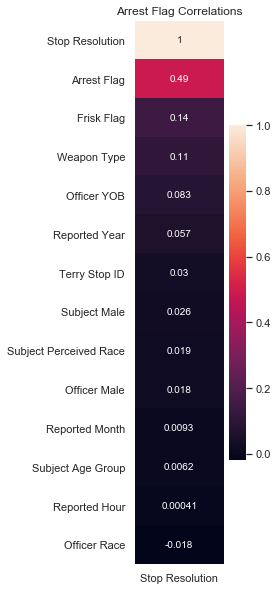

In [89]:
Corr = stops.corr()
Corr_arrestflag = pd.DataFrame(Corr['Stop Resolution'])
Corr_arrestflag.sort_values('Stop Resolution', ascending = False, inplace = True)

#Create heatmap to represent driving values:
fig = plt.figure(figsize=(2,10))
sns.heatmap(Corr_arrestflag, annot=True)
plt.title("Arrest Flag Correlations")

# Model

## OLS

In [90]:
stops_vars = stops[['Weapon Type', 'Subject Perceived Race', 'Subject Male', 'Subject Age Group', 'Frisk Flag']]
y = stops['Stop Resolution']
X = stops_vars.loc[:, stops_vars.columns != 'y']
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.25)
# Create an instance of the model. 
logreg = LogisticRegression() 
# Training the model. 
logreg.fit(X_train,y_train) 
# Do prediction. 
y_pred=logreg.predict(X_test)

In [91]:
from sklearn import metrics 
cnf_matrix = metrics.confusion_matrix(y_test, y_pred)
cnf_matrix

array([[8819,    0],
       [2945,    0]])

In [92]:
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))


Accuracy: 0.749659979598776


In [93]:
logit_model=sm.Logit(y,X)
result=logit_model.fit()
print(result.summary())

Optimization terminated successfully.
         Current function value: 0.562839
         Iterations 5
                           Logit Regression Results                           
Dep. Variable:        Stop Resolution   No. Observations:                47055
Model:                          Logit   Df Residuals:                    47050
Method:                           MLE   Df Model:                            4
Date:                Sat, 11 Dec 2021   Pseudo R-squ.:               -0.007550
Time:                        10:29:19   Log-Likelihood:                -26484.
converged:                       True   LL-Null:                       -26286.
Covariance Type:            nonrobust   LLR p-value:                     1.000
                             coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------
Weapon Type                0.5545      0.044     12.628      0.000       0.468      

In [94]:
X.columns

Index(['Weapon Type', 'Subject Perceived Race', 'Subject Male',
       'Subject Age Group', 'Frisk Flag'],
      dtype='object')

In [95]:
model_predictors = pd.DataFrame([])
model_predictors['Weapon Type'] = stops['Weapon Type']
model_predictors['Subject Perceived Race'] = stops['Subject Perceived Race']
model_predictors['Subject Male'] = stops['Subject Male']
model_predictors['Subject Age Group'] = stops['Subject Age Group']
model_predictors['Frisk Flag'] = stops['Frisk Flag']

In [96]:
model = logreg.fit(X, y)

#Create dictionary matching variable names to their corresponding coeffs
var_coefs = dict(zip(model_predictors.columns, model.coef_))

#Display variable names and coeffs
var_coefs

{'Weapon Type': array([0.52725645, 0.05771345, 0.03070671, 0.01638165, 0.61449201])}

In [97]:
model.intercept_

array([-1.41783191])

In [98]:
model_predictors.tail()

,Weapon Type,Subject Perceived Race,Subject Male,Subject Age Group,Frisk Flag
47050,0,1,1,6,0
47051,0,1,1,6,0
47052,0,1,1,6,1
47053,0,0,1,6,0
47054,1,1,1,6,1


In [99]:
def arrest_prediction():
   
    arrest = model.intercept_
    
#Weapon Present      
    weapon = input("Weapon Present?")
    weapon_v = 0.52725645 * (float(weapon))
    arrest += weapon_v
    
#Subject Race 
    srace = input("Subject Race?")
    srace_v = 0.05771345 * (float(srace))
    arrest += srace_v

#Subject Percieved Gender 
    sgender = input("Subject gender?")
    sgender_v = 0.03070671 * (float(sgender))
    arrest += sgender_v

#Subject Age Group
    sage = input("Subject Age Group?")
    sage_v = 0.01638165 * (float(sage))
    arrest += sage_v

#Frisk Flag  
    frisk = input("Frisk flag?")
    frisk_v = 0.61449201 * (float(frisk))
    arrest += frisk_v
    
   
    
    

    return 'The likelihood of arrest is {}'.format((arrest))

## Variable Key
- Weapon Present? 
    - 1 = Yes 
    - 0 = No
- Subject Race: 
    - 0 = White 
    - 1 = Non-white 
- Subject Gender 
    - 0 = Non-Male 
    - 1 = Male 
- Subject Age Group 
    - 1 = 1 - 17
    - 2 = 18 - 25
    - 3 = 26 - 35
    - 4 = 36 - 45
    - 5 = 46 - 55
    - 6 = 55 - 74
- Frisk Flag 
    - 0 = No 
    - 1 = Yes

In [100]:
arrest_prediction()

Weapon Present?1
Subject Race?1
Subject gender?1
Subject Age Group?1
Frisk flag?1


'The likelihood of arrest is [-0.17128164]'

### Question 
- Is there a way to put marginalized demographics up against demographic least likely to be arrested? (Separate out demographics based on arrest liklihood) 

## Random Forest  

In [109]:
#Splitting data into train and test: 
X = stops.loc[:, ['Subject Age Group', 'Stop Resolution', 'Weapon Type', 'Subject Male']]
y = stops.loc[:, ['Arrest Flag']]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 42)

In [112]:
# One-hot encode the training data:
from sklearn.preprocessing import OneHotEncoder
ohe = OneHotEncoder()

ohe.fit(X_train)
X_train_ohe = ohe.transform(X_train).toarray()
X_test_ohe = ohe.transform(X_test).toarray()

# Create a dataframe with both training and testing data to be used later:
ohe_stops1 = pd.DataFrame(X_train_ohe, columns=ohe.get_feature_names(X_train.columns))
ohe_stops2 = pd.DataFrame(X_test_ohe, columns=ohe.get_feature_names(X_test.columns))
ohe_stops = pd.concat([ohe_stops1,ohe_stops2])

In [122]:
from sklearn.metrics import accuracy_score,confusion_matrix,roc_curve, auc, f1_score, classification_report

def confusion_matrix_plot(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    
    # Add title and labels:
    plt.title(title)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    
    # Add axis scales and tick marks:
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    
    # Add labels to each cell:
    thresh = cm.max() / 2.
    # Iterate through confusion matrix and append labels to the plot:
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment='center',
                 color='white' if cm[i, j] > thresh else 'black')
        
    # Add legend:
    plt.colorbar()
    plt.show()
    
# Use Arrested and Not Arrested for 0 and 1 classes 
class_names = ['Arrested','Not Arrested']

/Users/molly/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  after removing the cwd from sys.path.


Random Forest Accuracy:  92.86675639300135 %
              precision    recall  f1-score   support

           0       0.93      1.00      0.96     13110
           1       0.50      0.00      0.01      1007

    accuracy                           0.93     14117
   macro avg       0.71      0.50      0.48     14117
weighted avg       0.90      0.93      0.89     14117



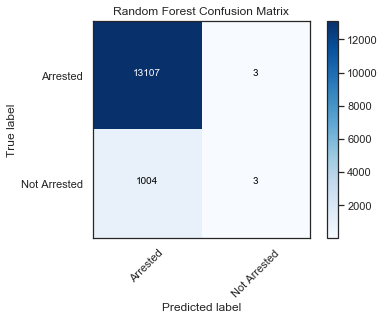

In [123]:
# Create the classifier, fit it on the training data and make predictions on the test set:
rforest = RandomForestClassifier(n_estimators=80, criterion = 'gini',max_depth=None, max_features=5, 
                                 min_samples_split=5)
rforest.fit(X_train_ohe, y_train)
y_pred = rforest.predict(X_test_ohe)

# Check the Accuracy:
print('Random Forest Accuracy: ', accuracy_score(y_test, y_pred)*100,'%')

# Print classification report:
print(classification_report(y_test, y_pred))

# Confusion Matrix for Random Forest:
cm_forest = confusion_matrix(y_test,y_pred)
confusion_matrix_plot(cm_forest, classes=class_names, title='Random Forest Confusion Matrix')

## K-Nearest Neighbors

In [125]:
def find_best_k(X_train, y_train, X_test, y_test, min_k=1, max_k=25):
    best_k = 0
    best_score = 0.0
    for k in range(min_k, max_k+1,2):
        knn = KNeighborsClassifier(n_neighbors=k, algorithm='brute')
        knn.fit(X_train, y_train.values.ravel())
        preds = knn.predict(X_test)
        accuracy = accuracy_score(y_test, preds)
        if accuracy > best_score:
            best_k = k
            best_score = accuracy
    
    print("Best Value for k: {}".format(best_k))
    print("Accuracy Score: {}".format(best_score))
    
print(find_best_k(X_train_ohe, y_train, X_test_ohe, y_test))

Best Value for k: 17
Accuracy Score: 0.9261882836296663
None
